This notebook takes an MWA observation and creates an image sequence from it using WSClean.
Roughly inspired by: <https://doi.org/10.3847/1538-4357/aa9cee>

In [1]:
from casacore.tables import table
import numpy as np
from astropy.time import Time, TimeDelta
from astropy.io import fits
import os
import shutil

Specify the path to one measurement set of the observation below.
You can download the desired data using the following steps:

1. Search observation in <https://asvo.mwatelescope.org/observations>
2. Request "Visibility Conversion Job" for observation. Recommended settings for sun observations:
	- Disable RFI Flagging (tends to flag solar bursts)
	- Enable basic calibration
3. Download the file and extract to a directory

The conversion job can take several hours to complete, and the resulting file can be very large (+200GB).

In [2]:
OBSERVATION_PATH = "/mnt/nas05/data02/tschai/1126847624_basic_calibration/1126847624_ch187-188.ms"
IMAGE_SIZE_PIXELS = 2048
SCALE_ARCSEC_PER_PIXEL = 5

WORK_DIR = os.path.join(os.getcwd(), "tmp")
RAW_DIR = os.path.join(WORK_DIR, "raw")
MERGED_DIR = os.path.join(WORK_DIR, "merged")

In [3]:
observation = table(OBSERVATION_PATH)
# Unlock for WSClean
observation.unlock()

Successful readonly open of default-locked table /mnt/nas05/data02/tschai/1126847624_basic_calibration/1126847624_ch187-188.ms: 24 columns, 4804992 rows


In [4]:
DAY_SECONDS = 60*60*24

intervals_center_mjd_seconds = observation.getcol('TIME')
intervals_size_seconds = observation.getcol('INTERVAL')

intervals_radius_seconds =  intervals_size_seconds/ 2.0
start_mjd = np.min(intervals_center_mjd_seconds - intervals_radius_seconds) / DAY_SECONDS
end_mjd = np.max(intervals_center_mjd_seconds + intervals_radius_seconds) / DAY_SECONDS

start_time = Time(start_mjd, format='mjd', scale='utc')
end_time = Time(end_mjd, format='mjd', scale='utc')

# Assume all intervals are the same size
assert np.all(intervals_size_seconds == intervals_size_seconds[0])
interval_size = TimeDelta(intervals_size_seconds[0], format='sec')
duration = (end_time - start_time)
interval_count = int(duration / interval_size)

print(f"Time Range: {start_time.iso} to {end_time.iso} ({duration.sec:.2f}s)")
print(f"Intervals: {interval_count} each {interval_size.sec}s")

Time Range: 2015-09-21 05:13:29.000 to 2015-09-21 05:18:20.000 (291.00s)
Intervals: 582 each 0.5s


In [ ]:
import subprocess
import os

try:
    shutil.rmtree(RAW_DIR)
except FileNotFoundError:
    pass
os.makedirs(RAW_DIR, exist_ok=True)

subprocess.run([
    "wsclean",
    # Create image sequence
    "-intervals-out", str(interval_count),
    # Scale for the sun is fixed
    "-size", str(IMAGE_SIZE_PIXELS), str(IMAGE_SIZE_PIXELS), "-scale", f"{SCALE_ARCSEC_PER_PIXEL}asec",
    # No image cleaning for now
    "-niter", "0",
    # Process each polarization separately
    "-join-polarizations", "-pol", "XX,YY",
    # Output black and white image
    "-channels-out" ,"1",
    OBSERVATION_PATH
    ], cwd=RAW_DIR)

In [6]:
try:
    shutil.rmtree(MERGED_DIR)
except FileNotFoundError:
    pass
os.makedirs(MERGED_DIR, exist_ok=True)

print("Merging polarizations to Stokes I...")
for i in range(interval_count):
    file_prefix = f"wsclean-t{i:04d}"
    
    xx_file_path = os.path.join(RAW_DIR, f"{file_prefix}-XX-image.fits")
    yy_file_path = os.path.join(RAW_DIR, f"{file_prefix}-YY-image.fits")
    if not (os.path.exists(xx_file_path) and os.path.exists(yy_file_path)):
        print(f"Skipping interval {i} due to missing XX or YY image.")
        continue
        
    stokes_i_filepath = os.path.join(MERGED_DIR, f"{file_prefix}-I-image.fits")

    with fits.open(xx_file_path) as hdul_xx, fits.open(yy_file_path) as hdul_yy:
        data_xx = np.squeeze(hdul_xx[0].data)
        header_template = hdul_xx[0].header # Use XX header as template
        data_yy = np.squeeze(hdul_yy[0].data)

    stokes_i_data = 0.5 * (data_xx + data_yy)
    
    # --- Header Modifications for Stokes I (2D image) ---
    header_template['BTYPE'] = 'Stokes I'
    header_template['NAXIS'] = 2 # Explicitly state it's a 2D image

    # Keywords to check and delete if they refer to axes > 2
    prefixes_to_clean = ['CTYPE', 'CRVAL', 'CRPIX', 'CDELT', 'CUNIT', 'NAXIS']
    keys_to_delete = []
    for key in list(header_template.keys()):
        for prefix in prefixes_to_clean:
            # Check if key starts with prefix and ends with a digit > NAXIS (which is 2)
            if key.startswith(prefix) and len(key) > len(prefix):
                try:
                    axis_num = int(key[len(prefix):])
                    if axis_num > header_template['NAXIS']:
                        del header_template[key]
                        break # Found a match for this key, no need to check other prefixes
                except ValueError: # Suffix is not purely numeric (e.g. CTYPE1A) - usually fine
                    pass
    # --- End Header Modifications ---

    fits.writeto(stokes_i_filepath, stokes_i_data, header_template, overwrite=True)
    
print("Stokes I FITS file creation complete.")

Merging polarizations to Stokes I...
Skipping interval 397 due to missing XX or YY image.
Skipping interval 398 due to missing XX or YY image.
Skipping interval 399 due to missing XX or YY image.
Skipping interval 400 due to missing XX or YY image.
Skipping interval 401 due to missing XX or YY image.
Skipping interval 402 due to missing XX or YY image.
Skipping interval 403 due to missing XX or YY image.
Skipping interval 404 due to missing XX or YY image.
Skipping interval 405 due to missing XX or YY image.
Skipping interval 406 due to missing XX or YY image.
Skipping interval 407 due to missing XX or YY image.
Skipping interval 408 due to missing XX or YY image.
Skipping interval 409 due to missing XX or YY image.
Skipping interval 410 due to missing XX or YY image.
Skipping interval 411 due to missing XX or YY image.
Skipping interval 412 due to missing XX or YY image.
Skipping interval 413 due to missing XX or YY image.
Skipping interval 414 due to missing XX or YY image.
Skipping 

In [10]:
import glob

print("Loading Stokes I data for animation...")
stokes_i_fits_files = sorted(glob.glob(os.path.join(MERGED_DIR, f"wsclean-t*-I-image.fits")))

all_stokes_i_data = [np.squeeze(fits.getdata(f)) for f in stokes_i_fits_files]
movie_data_stack = np.array(all_stokes_i_data)

print(f"Movie data shape: {movie_data_stack.shape}")

Loading Stokes I data for animation...
Movie data shape: (397, 2048, 2048)


 Text(0.5, 1.0, 'Solar Radio Emission (Stokes I) - Frame 198\n2015-09-21 05:15:08.000')]

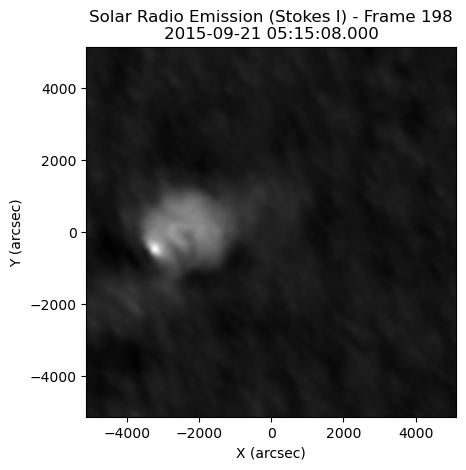

In [15]:
import numpy as np
from astropy.io import fits
from astropy.visualization import simple_norm, AsinhStretch
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
import glob
import os

HALF_ARCSEC = IMAGE_SIZE_PIXELS * SCALE_ARCSEC_PER_PIXEL / 2.0
IMG_EXTENT_ARCSEC = [-HALF_ARCSEC, HALF_ARCSEC, -HALF_ARCSEC, HALF_ARCSEC]

# Increase allowed size to 2GB
matplotlib.rcParams['animation.embed_limit'] = 2000

fig, ax = plt.subplots()

# Initial frame
initial_frame_data = movie_data_stack[0, :, :]
img = ax.imshow(
    initial_frame_data, cmap='gray', origin='lower', 
    vmin=initial_frame_data.min(),
    vmax=initial_frame_data.max(),
    extent=IMG_EXTENT_ARCSEC
)
ax.set_xlabel("X (arcsec)")
ax.set_ylabel("Y (arcsec)")
title_obj = ax.set_title(f"Solar Radio Emission (Stokes I) - Frame 0\n{start_time.iso}")

def update(frame):
    current_frame_data = movie_data_stack[frame, :, :]
    
    img.set_data(current_frame_data)
    img.set_clim(
        vmin=current_frame_data.min(),
        vmax=current_frame_data.max()
    )
    
    frame_time = start_time + (frame * interval_size)
    title_obj.set_text(f"Solar Radio Emission (Stokes I) - Frame {frame}\n{frame_time.iso}")
    
    return [img, title_obj]

# Create animation
ani = animation.FuncAnimation(
    fig, update,
    frames=movie_data_stack.shape[0], 
    interval=50,
    blit=True
)

# Show a frame from the middle
update(movie_data_stack.shape[0]//2)

In [16]:
from IPython.display import Video

mp4_filename = os.path.join(WORK_DIR, "stokes_i.mp4")
print(f"Saving animation to {mp4_filename}...")
ani.save(mp4_filename, writer='ffmpeg', fps=20, dpi=150)
print("Animation saved.")

display(Video(os.path.relpath(mp4_filename, os.getcwd())))

Saving animation to /home/tschai/STIX-MWA/tmp/stokes_i.mp4...
Animation saved.
